In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=UnicodeWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
def get_direct_link(shared_link):
    return 'https://drive.google.com/uc?export=download&id=' + shared_link.split('/')[-2]

link = "https://drive.google.com/file/d/1Uaj-eE2SNav93r_dQDGUYsDnFeUK9rt1/view?usp=drive_link"

direct_link = get_direct_link(link)
df = pd.read_csv(direct_link, encoding='utf-8')

In [3]:
train_df = df[~(df['date'] > '2019-01-00')].copy()
test_df = df[(df['date'] > '2019-01-00')].copy()

test_df.reset_index(inplace=True)

In [4]:
def build_training_data(features):
    x = np.array(train_df[features])
    y = np.array(train_df['outcome'])
    x = sm.add_constant(x)
    x = x.astype(float)
    return x, y

def train_regression(features):
    x, y = build_training_data(features)
    model = sm.OLS(y, x).fit()
    return model.params

def train_model(rank=True, wiki=True):
    features = ['inverse_avg']
    if rank:
        features.append('rankdist')
    if wiki:
        features.append('wikibuzz')
    return train_regression(features)

def model_prob(coef, inv_odds, rankdist=None, wikibuzz=None):
    prob = coef[0] + coef[1] * inv_odds  
    if rankdist is not None:
        prob += coef[2] * rankdist
    if wikibuzz is not None:
        prob += coef[-1] * wikibuzz
    return prob

def kelly(implied_prob, predicted_prob):
    return max(predicted_prob - ((1 - predicted_prob) / ((1 / implied_prob) - 1)), 0)

def profit(stake, implied_prob, outcome):
    return stake * (1 / implied_prob - 1) if outcome == 1 else -stake

def estimate_probabilities(test_data, coef, odds_provider, use_rank=True, use_wiki=True):
    if use_rank and use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], row['rankdist'], row['wikibuzz']), axis=1)
    elif use_rank:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], rankdist=row['rankdist']), axis=1)
    elif use_wiki:
        test_data['est_prob'] = test_data.apply(lambda row: model_prob(coef, row['inverse_avg'], wikibuzz=row['wikibuzz']), axis=1)
    else:
        test_data['est_prob'] = test_data['inverse_avg'].apply(lambda x: model_prob(coef, x))

    return test_data

def display_results(test_data, odds_provider):
    bet_considered = len(test_data[test_data[f'inverse_{odds_provider}'].notna()])
    bets_placed = len(test_data.loc[(test_data["profit"].notna()) & (test_data["profit"] != 0)])
    mean_overround = ((test_data.sort_values(by="match_id")[f"inverse_{odds_provider}"].rolling(2).sum().iloc[1::2].mean() - 1) * 100)
    total_stake = test_data['stake'].sum()
    total_return = test_data['profit'].sum()
    roi = (((total_return + total_stake) / total_stake) - 1) * 100
    
    results = {
        'Bets considered (2 * Matches)': bet_considered,
        'Number of bets placed': bets_placed,
        'Mean overround (%)': mean_overround,
        'Absolute amount bet': total_stake,
        'Absolute return': total_return,
        'ROI (%)': roi
    }
    
    return results

def show_results(test_data, coef, odds_provider, rank=True, wiki=True):
    test_data = estimate_probabilities(test_data, coef, odds_provider, rank, wiki)
    test_data['stake'] = [kelly(a, b) for a, b in zip(test_data[f'inverse_{odds_provider}'], test_data['est_prob'])]
    test_data['profit'] = [profit(a, b, c) for a, b, c in zip(test_data['stake'], test_data[f'inverse_{odds_provider}'], test_data['outcome'])]
    
    results = display_results(test_data, odds_provider)
    print(results)
    return results

def plot_results(test_df):
    test_df['cum_profit'] = test_df['profit'].cumsum()
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    test_df.plot('date', 'cum_profit', ax=ax)
    ax.set_ylabel('Absolute Return')
    ax.set_xlabel('Date')
    plt.show()


{'Bets considered (2 * Matches)': 5156, 'Number of bets placed': 312, 'Mean overround (%)': 6.4564991249188575, 'Absolute amount bet': 7.151004389194398, 'Absolute return': 1.2360930817859346, 'ROI (%)': 17.285586954103206}


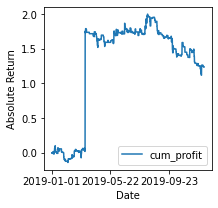

In [5]:
# preferred model on B365
coef = train_model()
show_results(test_df, coef, 'B365')
plot_results(test_df)


In [6]:
coef

array([-0.0414954 ,  1.02512999,  0.05469513,  0.00904175])

{'Bets considered (2 * Matches)': 5156, 'Number of bets placed': 276, 'Mean overround (%)': 6.4564991249188575, 'Absolute amount bet': 4.987843280939489, 'Absolute return': 1.4372911056210453, 'ROI (%)': 28.815883432294264}


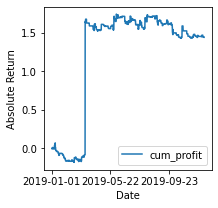

In [7]:
# preferred model on B365
coef = train_model(rank=False)
show_results(test_df, coef, 'B365', rank=False)
plot_results(test_df)

{'Bets considered (2 * Matches)': 5189, 'Number of bets placed': 2350, 'Mean overround (%)': -0.2277009070871583, 'Absolute amount bet': 76.62824688935555, 'Absolute return': 2.3407165178958547, 'ROI (%)': 3.054639265433856}


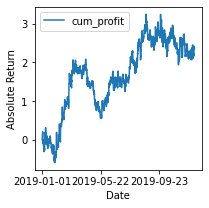

In [8]:
# preferred model on B365
coef = train_model()
show_results(test_df, coef, 'best')
plot_results(test_df)